# 准备数据

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original", data_home='./datasets/')
mnist

e:\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
e:\python\python36\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

## 查看图片

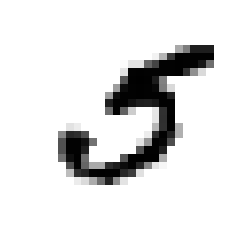

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

## 准备训练集和测试集

In [7]:
#划分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#混洗
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练二元分类

In [9]:
# 数据集中所有为5的置为True,所有不为5的置为False
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [10]:
#训练
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=300, tol=1e-3) #设置random_state来取得有复验性的结果
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=300,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

# 性能评估

## 用交叉验证集测量精度

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96745, 0.96765, 0.9682 ])

In [13]:
# 预测所有的均为非5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9129 , 0.90985, 0.9062 ])

## 混淆矩阵

In [14]:
# 使用cross_val_predict()预测
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [15]:
# 生成混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53786,   793],
       [ 1141,  4280]], dtype=int64)

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## [准确率和召回率](https://github.com/coldJune/machineLearning/blob/master/machineLearningCourseraNote/Note6.pdf)

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)# 4280/(4280+793)

0.8436822393061305

In [18]:
recall_score(y_train_5, y_train_pred)# 4280/(4280+1141)

0.7895222283711493

In [19]:
# f1score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.8157042119306271

## 准确率/召回率权衡

In [20]:
# 返回该实例的度量分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([1719.30568805])

In [21]:
threshold = 0
y_som_digit_pred = (y_scores > threshold)
y_som_digit_pred

array([ True])

In [22]:
threshold = 5000
y_som_digit_pred = (y_scores > threshold)
y_som_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")#使用decision_function代替predictions

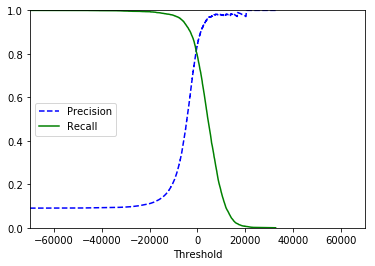

In [24]:
# 画出准确率和召回率的曲线
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.xlim([-70000, 70000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
#90%precision
y_train_pred_90 = (y_scores > 20000)
precision_score(y_train_5, y_train_pred_90)

0.9743589743589743

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.007009776793949456

## [ROC曲线](http://coldjune.com/2018/05/23/AdaBoost%E5%85%83%E7%AE%97%E6%B3%95/#%E6%AD%A3%E7%A1%AE%E7%8E%87%E3%80%81%E5%8F%AC%E5%9B%9E%E7%8E%87%E5%8F%8AROC%E6%9B%B2%E7%BA%BF)

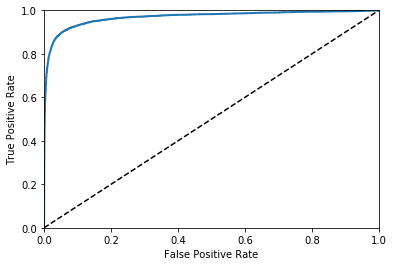

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9687033573780276

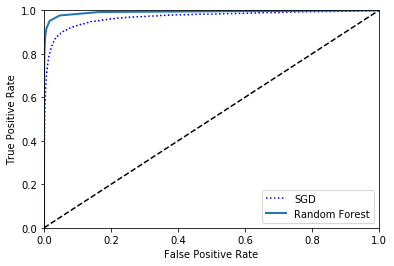

In [29]:
#随机森林的ROC曲线
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921742440641518

# 多级分类

In [31]:
sgd_clf.fit(X_train, y_train)#底层训练了10个二元分类器，选择最大的
sgd_clf.predict([some_digit])

e:\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([5.])

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -9482.30311837, -28541.31936371,  -6102.76466388,
         -2810.6306152 , -10769.43978963,   1719.30568805,
        -12631.34973763, -12183.70942304, -11311.70845504,
        -17434.09996592]])

In [33]:
np.argmax(some_digit_scores)

5

In [34]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [35]:
sgd_clf.classes_[5]

5.0

In [36]:
#使用一对一的训练器
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=500, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [40]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [43]:

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

e:\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.87337532, 0.87969398, 0.88058209])

In [49]:
# 缩减输入
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

e:\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
e:\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
e:\python\python36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91296741, 0.90744537, 0.91258689])